In [1]:
import numpy as np
import pandas as pd
from os import listdir, makedirs, walk
from os.path import isdir, isfile, join, exists, expanduser
from tqdm import tqdm_notebook
import datetime

## View underlying data

In [2]:
train_folder      = 'data/train/'
valid_folder      = 'data/validation/'
weights_folder    = 'models/'

bottleneck_features_train_npy = 'bottleneck_features_train.npy'
bottleneck_features_valid_npy = 'bottleneck_features_valid.npy'
bottleneck_labels_train_npy = 'bottleneck_labels_train.npy'
bottleneck_labels_valid_npy = 'bottleneck_labels_valid.npy'

top_model_epochs = 50
complete_model_epochs = 20

augmented_images_multiply_factor = 3

# Create weights folder to save model weights
if not exists(weights_folder):
    makedirs(weights_folder)
    
ext = '.jpg'
classes = [fldr for fldr in listdir(train_folder) if isdir(join(train_folder, fldr))]
num_classes = len(classes)
train_samples = sum([len(files) for r, d, files in walk(train_folder)])
valid_samples = sum([len(files) for r, d, files in walk(valid_folder)])

print ("Classes: {}, Training samples: {}, Validation samples: {}".format(num_classes, train_samples, valid_samples))

Classes: 120, Training samples: 8122, Validation samples: 2100


/home/paperspace/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


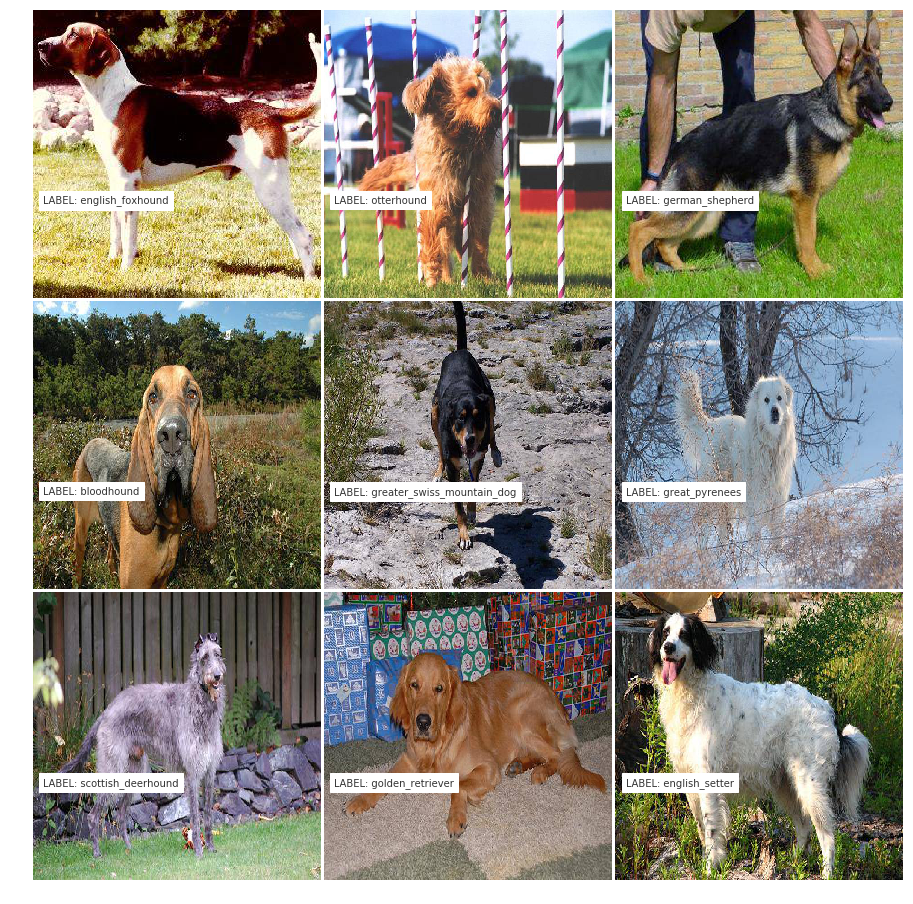

In [3]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# options
INPUT_SIZE = 299
BATCH_SIZE = 16

fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

for i, cls in enumerate(np.random.choice(classes, 9)):
    ax = grid[i]
    img_file = np.random.choice(listdir(join(train_folder, cls)))
    img = image.load_img(join(train_folder, cls, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 200, 'LABEL: %s' % cls, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

## Adapting [Keras example](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) for Xception model with multiclass classification

1. Create base model and save bottleneck features
2. Train top-model with bottleneck features
3. Setup data to flow from directory with augmentation
4. Fine tune base model

In [4]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, deserialize
from keras.utils import to_categorical
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator, array_to_img

## 1. Create base model and save bottleneck features

In [5]:
# Creating wrapper for input preprocessing from https://nbviewer.jupyter.org/gist/embanner/6149bba89c174af3bfd69537b72bca74 
def preprocess_input_xception(x):
    """Wrapper around keras.applications.xception.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.xception.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.xception import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [6]:
base_model = xception.Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)))

In [7]:
if not exists(bottleneck_features_train_npy):
    # Set up data generator for bottleneck features - only need preprocessing (no augmentation)
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)

    # Generate bottleneck features for training data, and accompanying labels
    generator = datagen.flow_from_directory(
        train_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_train = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_train_npy, bottleneck_features_train)

    bottleneck_labels_train = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_train_npy, bottleneck_labels_train)
    
else:
    bottleneck_features_train = np.load(bottleneck_features_train_npy)
    bottleneck_labels_train = np.load(bottleneck_labels_train_npy)

In [8]:
if not exists(bottleneck_features_valid_npy):
    # Generate bottleneck features for validation data, and accompanying labels
    generator = datagen.flow_from_directory(
        valid_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_valid = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_valid_npy, bottleneck_features_valid)

    bottleneck_labels_valid = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_valid_npy, bottleneck_labels_valid)

else:
    bottleneck_features_valid = np.load(bottleneck_features_valid_npy)
    bottleneck_labels_valid = np.load(bottleneck_labels_valid_npy)    

## 2. Create and train top-model with bottleneck features

In [9]:
top_model = Sequential()

# Based on https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# top_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))

# Based on https://www.kaggle.com/abnera/transfer-learning-keras-xception-cnn - the best performance
top_model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train.shape[1:]))

# Based on https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/
# top_model.add(BatchNormalization(input_shape=bottleneck_features_train.shape[1:]))
# top_model.add(GlobalAveragePooling2D())
# top_model.add(Dropout(0.5))
# top_model.add(Dense(1024, activation='relu'))
# top_model.add(Dropout(0.5))
 
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='nadam',
              loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# From https://github.com/bckenstler/CLR for Cyclical Learning Rate
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [11]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

# save weights of best training epoch: monitor either val_loss or val_acc
STAMP = "{}_top_model".format(datetime.datetime.now().strftime("%Y-%m-%d"))
top_model_weights_path = "models/{}.h5".format(STAMP)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 16000
clr = CyclicLR(base_lr=0.0002,
               max_lr=0.002,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

callbacks_list = [
    ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    clr
]

top_model.fit(bottleneck_features_train, bottleneck_labels_train,
              batch_size=BATCH_SIZE,
              epochs=top_model_epochs,
              callbacks=callbacks_list,
              validation_data=(bottleneck_features_valid, bottleneck_labels_valid))

Train on 8122 samples, validate on 2100 samples
Epoch 1/50
8122/8122 [==============================] - 8s 1ms/step - loss: 2.3374 - acc: 0.7075 - val_loss: 0.9132 - val_acc: 0.8814

Epoch 00001: val_acc improved from -inf to 0.88143, saving model to models/2018-05-08_top_model.h5
Epoch 2/50
8122/8122 [==============================] - 7s 816us/step - loss: 0.5915 - acc: 0.9062 - val_loss: 0.4814 - val_acc: 0.8929

Epoch 00002: val_acc improved from 0.88143 to 0.89286, saving model to models/2018-05-08_top_model.h5
Epoch 3/50
8122/8122 [==============================] - 7s 815us/step - loss: 0.3620 - acc: 0.9227 - val_loss: 0.3832 - val_acc: 0.8905

Epoch 00003: val_acc did not improve from 0.89286
Epoch 4/50
8122/8122 [==============================] - 7s 820us/step - loss: 0.2789 - acc: 0.9329 - val_loss: 0.3453 - val_acc: 0.8929

Epoch 00004: val_acc did not improve from 0.89286
Epoch 5/50
8122/8122 [==============================] - 7s 815us/step - loss: 0.2293 - acc: 0.9389 - val_

## 3. Setup data to flow from directory with augmentation

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=train_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_xception)
valid_generator = valid_datagen.flow_from_directory(directory=valid_folder,
                                                              target_size=(INPUT_SIZE,INPUT_SIZE),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')

Found 8122 images belonging to 120 classes.
Found 2100 images belonging to 120 classes.


## 4. Create and fine complete model

In [13]:
# base_model = xception.Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)))

# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(num_classes, activation='softmax'))

top_model.load_weights(top_model_weights_path)

# Stack top_model on top
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

#for i, layer in enumerate(model.layers):
#    print ('Layer #: {}, Name: {}'.format(i, layer.name))

for layer in model.layers[:126]:
    layer.trainable = False
for layer in model.layers[126:]:
    layer.trainable = True
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [ ]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

# save weights of best training epoch: monitor either val_loss or val_acc
STAMP = "{}_complete_model".format(datetime.datetime.now().strftime("%Y-%m-%d"))
complete_model_weights_path = "models/{}.h5".format(STAMP)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 1200
clr = CyclicLR(base_lr=0.0002,
               max_lr=0.002,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

callbacks_list = [
    ModelCheckpoint(complete_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0),
    clr
]

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_samples // BATCH_SIZE,
                           epochs=complete_model_epochs,
                           callbacks=callbacks_list,
                           validation_data=valid_generator,
                           validation_steps=valid_samples // BATCH_SIZE)

Epoch 1/20
507/507 [==============================] - 239s 472ms/step - loss: 0.9093 - acc: 0.7310 - val_loss: 0.6147 - val_acc: 0.8092

Epoch 00001: val_acc improved from -inf to 0.80916, saving model to models/2018-05-08_complete_model.h5
Epoch 2/20
507/507 [==============================] - 193s 382ms/step - loss: 0.9663 - acc: 0.7153 - val_loss: 0.7249 - val_acc: 0.7872

Epoch 00002: val_acc did not improve from 0.80916
Epoch 3/20
507/507 [==============================] - 194s 382ms/step - loss: 0.8640 - acc: 0.7375 - val_loss: 0.6492 - val_acc: 0.8010

Epoch 00003: val_acc did not improve from 0.80916
Epoch 4/20
373/507 [=====================>........] - ETA: 44s - loss: 0.6253 - acc: 0.8066

Results with original approach:

Epoch 1/50
573/573 [==============================] - 188s 329ms/step - loss: 2.6888 - acc: 0.4172 - val_loss: 0.5156 - val_acc: 0.8356

Epoch 2/50
573/573 [==============================] - 186s 325ms/step - loss: 1.1958 - acc: 0.6704 - val_loss: 0.4518 - val_acc: 0.8423

Epoch 3/50
573/573 [==============================] - 186s 325ms/step - loss: 1.2034 - acc: 0.6921 - val_loss: 0.4862 - val_acc: 0.8519

Epoch 4/50
573/573 [==============================] - 185s 323ms/step - loss: 1.2603 - acc: 0.6965 - val_loss: 0.4370 - val_acc: 0.8673

Epoch 5/50
573/573 [==============================] - 186s 324ms/step - loss: 1.2512 - acc: 0.7045 - val_loss: 0.4166 - val_acc: 0.8644

Epoch 6/50
 98/573 [====>.........................] - ETA: 2:21 - loss: 1.0983 - acc: 0.7392